In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Helper Functions

def nCr(n, r):
    ''' Standard nCr Calculation
    '''
    return (fact(n) / (fact(r)  * fact(n - r))) 
  
def fact(n): 
    ''' Standard factorial calculation
    '''
    res = 1
    for i in range(2, n+1): 
        res = res * i 
    return res 

In [3]:
# Reference: http://graphics.cs.ucdavis.edu/education/CAGDNotes/Bernstein-Polynomials.pdf
# Similar Reference: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.897.2894&rep=rep1&type=pdf 
def calc_bernstein(i, j, n):
    ''' For degree n bernstein polynmial, calculates coeffecient at position i,j
    '''
    temp = (-1) ** (i-j)
    return temp * nCr(n, i) * nCr(i, j)

def make_bern(n):
    ''' Creates bernstein coefficient matrix of size n
        Look at references: http://graphics.cs.ucdavis.edu/education/CAGDNotes/Bernstein-Polynomials.pdf
        and https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.897.2894&rep=rep1&type=pdf 
        # B(t) = [1 t t^2...t^n] * make_bern(n) * [c0 c1 c2...cn] = [b0 b1 b2..bn] is the equation we're going for
    '''
    mat = []
    for i in range(n+1):
        temp = []
        for j in range(n+1):
            if i<j:
                temp.append(0)
            else:
                temp.append(calc_bernstein(i, j, n))
        mat.append(temp)
    return np.array(mat)

In [4]:
def calc_coef(derivative, j):
    if derivative == 0:
        return 1
    else:
        return j * calc_coef(derivative-1, j-1)
    
def eval_differentiation(bernstein_coef_mat, t, derivative):
    ''' Will generically calculate the differentiation of the bernstein polynomial
        derivative is 0 for no differentiation            [position]
                      1 for first differentiation         [velocity]
                      2 for second differentiation ...    [acceleration]
                      ...
        t is the time at which the differentiation is evaluated
        bernstein_coef_mat is what was calculated from make_bern
    '''
    temp = []
    x = len(bernstein_coef_mat)
    for i in range(x):
        val = 0
        for j in range(x):
            if j-derivative < 0:
                val += 0
            else: 
                val += calc_coef(derivative, j) * bernstein_coef_mat[j][i] * t **(j-derivative)
        temp.append(val)
    return temp

In [5]:
# Generic form of the list to be passed [{'derivative': d, 'dims': [x, y, z...], 'time': t}, ...]
# For position we would put: 
# {'derivative': 0, 'dims': [xpos, ypos], 'time': t} 
# if the robot is to be at (xpos, ypos) at timestep t
# Similarly for velocity we would put:
# {'derivative': 1, 'dims': [xvel, yvel], 'time': t} 
# if the robot has a velocity (xvel, yvel) at timestep t   [xvel in x direction and yvel in y direction]


# the above list of dictionary can be expressed concisely as a list of tuples instead, to save space
# constraints [(derivative, (x, y, z...), time) ....]


def construct_poly(constraints, dimensions):
    ''' Function used to construct a bernstein polynomial. Dimensions refers to how many
        dimensions we need to keep track of (2d, 3d, ...). Takes integer 2, 3, 4 ... n
        constraints are given in the form of a list of tuples
        General form: [(derivative, (x, y, z...), time) ....]
    '''
    num_constraints = len(constraints) # num_constraints
    bern_coefs = make_bern(num_constraints-1)
    M = []
    b = []
    for i in range(dimensions):
        b.append([])
    for con in constraints:
        coefs = eval_differentiation(bern_coefs, con[2], con[0])
        assert(len(con[1]) == dimensions)
        for i, dim in enumerate(con[1]):
            b[i].append(dim)
        M.append(coefs)
    
    M = np.array(M)
    b = np.array(b)
    c = []
    for b_dim in b:
        c.append(np.linalg.inv(M) @ b_dim.T)
    return c

def output_at_t(derivative, c_dim, t, bern_coefs):
    ''' Helper function
        evaluates a particular dimension's coefficients at a particular instant t
    '''
    output = []
    output.append(np.array(eval_differentiation(bern_coefs, t, derivative)) @ c_dim.T)
    return np.array(output)

def calc_outputs(c, derivative, time):
    ''' Function to evaluate the bernstein polynomial over a time sequence. 
        c refers to the coeffecients calculated by the construct_poly function
        derivative refers to which derivative of the function you want the output of.
        ex. 0 => position, 1=>velocity, 2=>acceleration ...
    '''
    num_constraints = len(c[0])
    bern_coefs = make_bern(num_constraints-1)
    output = []
    for c_dim in c:
        output.append([output_at_t(derivative, c_dim, t, bern_coefs) for t in time])
    return np.array(output)

def help_plot(arr, time):
    ''' Helper function to plot the outputs
    '''
    for dimension in arr:
        plt.plot(dimension)
        plt.show()

The advantage of this method is that a constraint can easily be added to the system, with no change in code.
Try adding one!

In [6]:
time = np.arange(0, 5.5, 0.1).tolist()
constraints = [
    (0, (3, 0), 0), # pos, at time 0 is (3, 0)
    (1, (-2, -3), 2), # vel at time 2 is (-2, -3)
    (0, (9, 5), 5), # pos at time 5 will be (9, 5)
    (1, (0, 0), 0), # vel at time 0 will be (0, 0)
    (1, (0, 0), 5), # vel at time 5 will be (0, 0)
    (2, (2, -3), 2.2), # acc at time 2.2 will be (2, -3)
    (0, (5, 3), 3), # pos at time 3 will be (5, 3)
    (0, (4, 2.5), 2.5) # pos at time 2.5 will be (4, 2.5)
]

In [7]:
c = construct_poly(constraints, 2)
positions = calc_outputs(c, 0, time)
velocities = calc_outputs(c, 1, time)
accs = calc_outputs(c, 2, time)

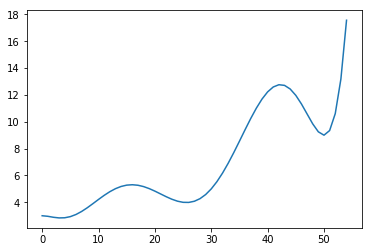

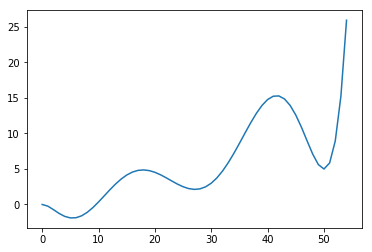

In [8]:
help_plot(positions, time) 
# help_plot(velocities, time)
# help_plot(accs, time,)